### Validation using an independent dataset (MMRF-TARGET)

In [31]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.ensemble import RandomForestRegressor

In [32]:
# load dataset
df = pd.read_csv('./resources/MMRF_benchmark/MMRF_TARGET_dataset.csv')
df.shape

(556, 33)

In [33]:
cols = ['downstream_exon_count', 'last_exon', 'PTC_to_start_codon',
        'dist_to_stop_codon', 'PTC_exon_length', 'PTC_to_intron','upstream_exon_count',
        'mRNA_half_life','50nt_to_last_EJ','LOEUF', 'AF', '5UTR_length', '3UTR_length', 'Transcript_length']

df[cols].head(1)

,downstream_exon_count,last_exon,PTC_to_start_codon,dist_to_stop_codon,PTC_exon_length,PTC_to_intron,upstream_exon_count,mRNA_half_life,50nt_to_last_EJ,LOEUF,AF,5UTR_length,3UTR_length,Transcript_length
0,19,0,4189,4718,990,31,10,315.133085,0,0.557,0.0,349,4719,9257


In [34]:
df[cols].isnull().sum()

downstream_exon_count     0
last_exon                 0
PTC_to_start_codon        0
dist_to_stop_codon        0
PTC_exon_length           0
PTC_to_intron             0
upstream_exon_count       0
mRNA_half_life            0
50nt_to_last_EJ           0
LOEUF                    74
AF                        0
5UTR_length               0
3UTR_length               0
Transcript_length         0
dtype: int64

In [35]:
df = df.loc[df['LOEUF'].notnull()].reset_index(drop=True)
df.shape

(482, 33)

In [36]:
regr = pickle.load(open('./nmd_eff_predictor', 'rb'))

def predict_NMD_efficiency(downstream_exon_count:int, last_exon:int, PTC_to_start_codon:int, 
                           dist_to_stop_codon:int, PTC_exon_length:int, PTC_to_intron:int, upstream_exon_count:int, 
                           mRNA_half_life:float, c50nt_to_last_EJ:int, LOEUF:float, AF:float,
                           UTR5_length:int, UTR3_length:int, Transcript_length:int) -> float:
    
    input_value =[[downstream_exon_count, last_exon, PTC_to_start_codon,
                   dist_to_stop_codon, PTC_exon_length, PTC_to_intron, upstream_exon_count,
                   mRNA_half_life, c50nt_to_last_EJ, LOEUF, AF,
                   UTR5_length, UTR3_length, Transcript_length]]
    
    assert sum([np.isnan(value) for value in input_value[0]]) == 0, 'Replace NaN value'
    
    pred = regr.predict(input_value)[0]
    
    return pred


def predict_NMD_efficiency_df(examples):
    df = pd.DataFrame(examples)

    assert df.isnull().sum().sum() == 0, 'Replace NaN value'

    pred = regr.predict(df)

    return pred

In [37]:
pred = regr.predict(df[cols])
c, p = stats.pearsonr(pred, df['NMD_efficiency'])
print("Pearson R :" , c)
print("P-value : " , p)

Pearson R : 0.466591440883764
P-value :  1.984116032299442e-27


Pearson R: 0.46659144088376403
P-value: 1.984116032299442e-27


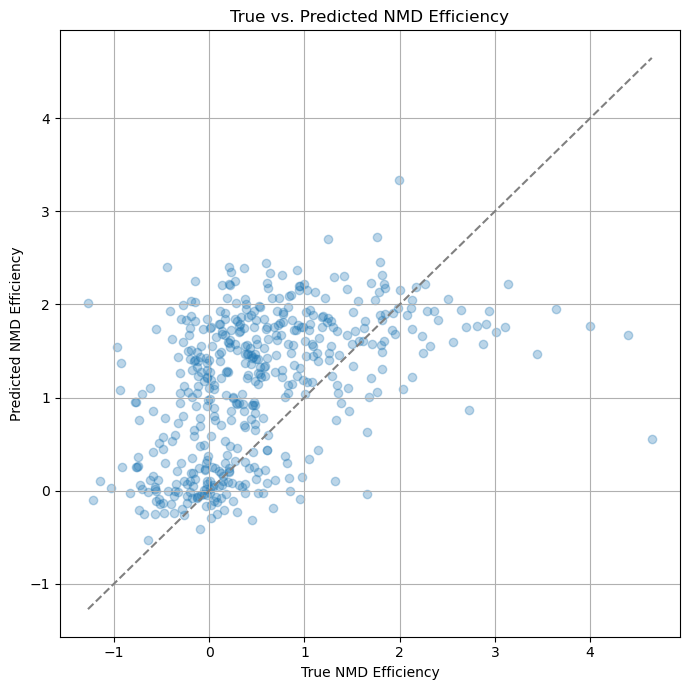

In [38]:
y_true = df['NMD_efficiency']
y_pred = regr.predict(df[cols]) # = pred

# Pearson correlation
c, p = stats.pearsonr(y_pred, y_true)
print("Pearson R:", c)
print("P-value:", p)

# min / max value for line
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())

# Plot: True vs Predicted
plt.figure(figsize=(7, 7))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot([min_val, max_val], [min_val, max_val], '--', color='gray')
plt.xlabel("True NMD Efficiency")
plt.ylabel("Predicted NMD Efficiency")
plt.title("True vs. Predicted NMD Efficiency")
plt.grid(True)
plt.tight_layout()
plt.show()

### Try for own Model

In [39]:
# merge NMD_Scanner Output von MMRF mit dem NMD_efficiency score vom Original TCGA Benchmark
df = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/MMRF_benchmark/MMRF_TARGET_dataset_final_nmd_results.csv')
df2 = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/MMRF_benchmark/MMRF_TARGET_dataset.csv')

# 1. Remove transcript version number from NMD Scanner output (df)
df['transcript_id'] = df['transcript_id'].str.split('.').str[0]

# 2. Adjust start_variant position (+1) to match TCGA coordinates
df['start_variant'] = df['start_variant'] + 1
#df['end_variant'] = df['end_variant'] - 1

# 3. Rename TCGA columns to match NMD Scanner
df2 = df2.rename(columns={
    'Transcript_ID': 'transcript_id',
    'start': 'start_variant'
})

# 4. Select only relevant columns from TCGA
df2_subset = df2[['transcript_id', 'start_variant', 'NMD_efficiency']]

# 5. Merge
df_merged = pd.merge(df, df2_subset, on=['transcript_id', 'start_variant'], how='inner')

# ✅ Inspect result
print("Merged shape:", df_merged.shape)
print("Missing NMD_efficiency values:", df_merged['NMD_efficiency'].isnull().sum())
print(df_merged[['transcript_id', 'start_variant', 'NMD_efficiency']].head())

Merged shape: (549, 72)
Missing NMD_efficiency values: 0
     transcript_id  start_variant  NMD_efficiency
0  ENST00000038176       58609624        0.710493
1  ENST00000040738       13576985        0.022368
2  ENST00000155093        2979509       -0.019109
3  ENST00000156471       34857043        0.040062
4  ENST00000202917      112917610        0.987014


In [40]:
# add distance to stop codon feature --> will it be a problem later on when I want to include it in AbExp?
df_merged["stop_codon_distance_nmd"] = df_merged["ref_first_stop_pos"] - df_merged["alt_first_stop_pos"]

In [41]:
# Select the columns that we want to have as X (our features)
cols = ['start_loss', 'stop_loss', 'nmd_last_exon_rule', 'nmd_50nt_penultimate_rule', 'nmd_long_exon_rule', 'nmd_start_proximal_rule', 'nmd_single_exon_rule', 'nmd_escape', # nmd escape = X or Y?
        'utr3_length', 'utr5_length', 'alt_transcript_length', 'total_exon_count', 'upstream_exon_count', 'downstream_exon_count', 'ptc_to_start_codon', 'ptc_exon_length', 
        'stop_codon_distance_nmd'] 

df_merged[cols].head(1)

,start_loss,stop_loss,nmd_last_exon_rule,nmd_50nt_penultimate_rule,nmd_long_exon_rule,nmd_start_proximal_rule,nmd_single_exon_rule,nmd_escape,utr3_length,utr5_length,alt_transcript_length,total_exon_count,upstream_exon_count,downstream_exon_count,ptc_to_start_codon,ptc_exon_length,stop_codon_distance_nmd
0,False,False,False,False,False,False,False,False,222,598,3574.0,31.0,5.0,25.0,666.0,124.0,2085.0


In [42]:
df_merged[cols].isnull().sum()

start_loss                    0
stop_loss                     0
nmd_last_exon_rule            0
nmd_50nt_penultimate_rule     0
nmd_long_exon_rule            0
nmd_start_proximal_rule       0
nmd_single_exon_rule          0
nmd_escape                    0
utr3_length                   0
utr5_length                   0
alt_transcript_length        39
total_exon_count              1
upstream_exon_count           1
downstream_exon_count         1
ptc_to_start_codon           11
ptc_exon_length               1
stop_codon_distance_nmd      39
dtype: int64

In [43]:
# drop null values
df_merged = df_merged.loc[df_merged['alt_transcript_length'].notnull()].reset_index(drop=True)
df_merged = df_merged.loc[df_merged['ptc_to_start_codon'].notnull()].reset_index(drop=True)
df.shape

(2452, 71)

In [44]:
df_merged[cols].isnull().sum()

start_loss                   0
stop_loss                    0
nmd_last_exon_rule           0
nmd_50nt_penultimate_rule    0
nmd_long_exon_rule           0
nmd_start_proximal_rule      0
nmd_single_exon_rule         0
nmd_escape                   0
utr3_length                  0
utr5_length                  0
alt_transcript_length        0
total_exon_count             0
upstream_exon_count          0
downstream_exon_count        0
ptc_to_start_codon           0
ptc_exon_length              0
stop_codon_distance_nmd      0
dtype: int64

In [45]:
regr = pickle.load(open('./nmd_eff_predictor2', 'rb'))

def predict_NMD_efficiency(start_loss:bool, stop_loss:bool, nmd_last_exon_rule:bool, nmd_50nt_penultimate_rule:bool, 
                           nmd_long_exon_rule:bool, nmd_start_proximal_rule:bool, nmd_single_exon_rule:bool, nmd_escape:bool,
                           utr3_length:int, utr5_length:int, alt_transcript_length:float, total_exon_count:float, 
                           upstream_exon_count:float, downstream_exon_count:float, ptc_to_start_codon:float, ptc_exon_length:float,
                           stop_codon_distance_nmd:float):
    
    input_value =[[start_loss, stop_loss, nmd_last_exon_rule, nmd_50nt_penultimate_rule, nmd_long_exon_rule, nmd_start_proximal_rule, 
                   nmd_single_exon_rule, nmd_escape, utr3_length, utr5_length, alt_transcript_length, total_exon_count, 
                   upstream_exon_count, downstream_exon_count, ptc_to_start_codon, ptc_exon_length, stop_codon_distance_nmd]]
    
    assert sum([np.isnan(value) for value in input_value[0]]) == 0, 'Replace NaN value'
    
    pred = regr.predict(input_value)[0]
    
    return pred


def predict_NMD_efficiency_df(examples):
    df_merged = pd.DataFrame(examples)

    assert df_merged.isnull().sum().sum() == 0, 'Replace NaN value'

    pred = regr.predict(df_merged)

    return pred

In [46]:
pred = regr.predict(df_merged[cols])
c, p = stats.pearsonr(pred, df_merged['NMD_efficiency'])
print("Pearson R :" , c)
print("P-value : " , p)

Pearson R : 0.41612179483225914
P-value :  1.0824934068899665e-22


Pearson R: 0.41612179483225914
P-value: 1.0824934068899665e-22


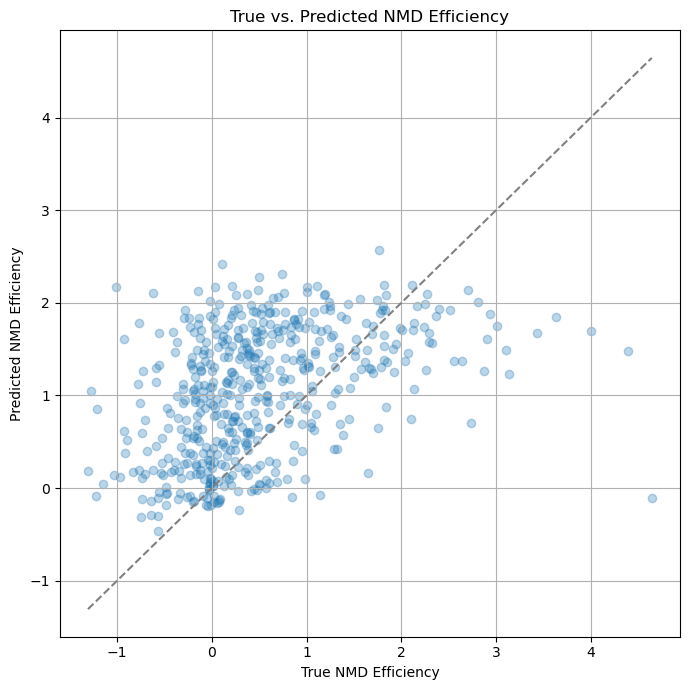

In [47]:
y_true = df_merged['NMD_efficiency']
y_pred = regr.predict(df_merged[cols]) # = pred

# Pearson correlation
c, p = stats.pearsonr(y_pred, y_true)
print("Pearson R:", c)
print("P-value:", p)

# min / max value for line
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())

# Plot: True vs Predicted
plt.figure(figsize=(7, 7))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot([min_val, max_val], [min_val, max_val], '--', color='gray')
plt.xlabel("True NMD Efficiency")
plt.ylabel("Predicted NMD Efficiency")
plt.title("True vs. Predicted NMD Efficiency")
plt.grid(True)
plt.tight_layout()
plt.show()